In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_gbq
import matplotlib.pyplot as plt
import plotly.express as px

from pandas_profiling import ProfileReport

from pathlib import Path

In [2]:
#Define the paths of the directories
current_dir=Path('.').resolve()
#Returns to the directory’s parent folder
project_dir=Path(current_dir).parent
print(current_dir)
print(project_dir)

C:\Users\ANNIE\Documents\ESEIT\BIG DATA\Notebooks
C:\Users\ANNIE\Documents\ESEIT\BIG DATA


In [3]:
file_data=os.path.join(project_dir,"Data","RAW","archive","Housing.csv")
data=pd.read_csv(file_data)

In [4]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# Exploratory Data Analysis (EDA)

In [5]:
report=ProfileReport(df=data,minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
target='price'

num_cols=['area']
ord_cols=['bedrooms','bathrooms','stories']
cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

<AxesSubplot:xlabel='area', ylabel='price'>

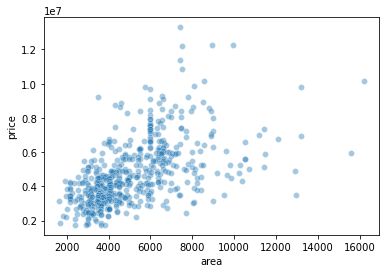

In [7]:
sns.scatterplot(x='area',y='price',data=data,alpha=0.4)

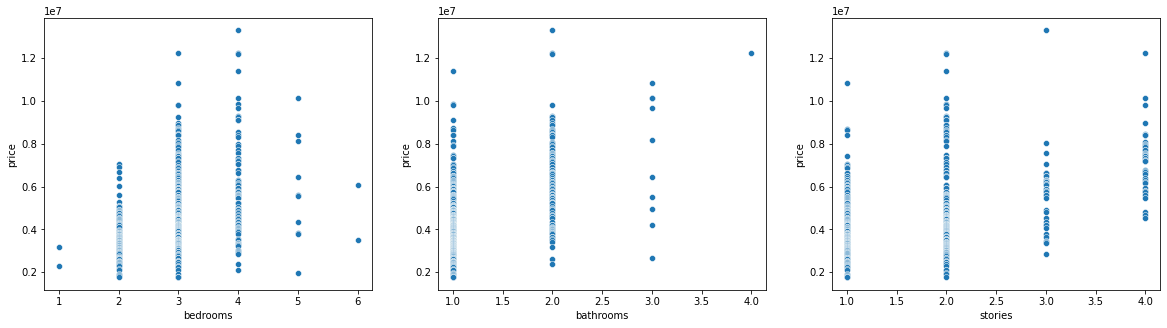

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5) )
axes = axes.flatten()

for i, col in enumerate(ord_cols):
    sns.scatterplot(x=col, y='price', data=data, ax=axes[i])

# Feature Engineering

- Converting Numeric cols to categorical cols
- New variables
- One-hot encoder

In [9]:
data['area'].quantile([0.20,0.4,0.6,0.8])

0.2    3450.0
0.4    4065.0
0.6    5400.0
0.8    6600.0
Name: area, dtype: float64

In [10]:
data['area_cat']=pd.cut(data['area'],
                        bins=[0.,3450,4065,5400,6600,np.inf],
                        labels=[1,2,3,4,5])
data['area_cat'].value_counts()

1    112
3    112
5    108
4    107
2    106
Name: area_cat, dtype: int64

<AxesSubplot:xlabel='area_cat', ylabel='price'>

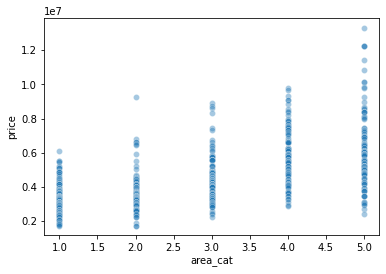

In [11]:
sns.scatterplot(x='area_cat',y='price',data=data,alpha=0.4)

In [12]:
corr_matrix=data.corr()
corr_matrix
#corr_matrix['price'].sort_values(ascending=False)

,price,area,bedrooms,bathrooms,stories,parking
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.384394
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.352980
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,0.139270
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.177496
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.045547
parking,0.384394,0.352980,0.139270,0.177496,0.045547,1.000000


<AxesSubplot:>

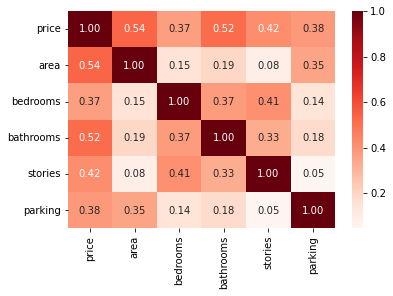

In [13]:
sns.heatmap(corr_matrix, cmap='Reds', annot=True, fmt=".2f")

In [14]:
data["lux_home"] = data["bathrooms"] + data["bedrooms"] + data["parking"]
corr_matrix = data.corr()
corr_matrix["price"].sort_values(ascending=False)

price        1.000000
lux_home     0.588013
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64

<AxesSubplot:>

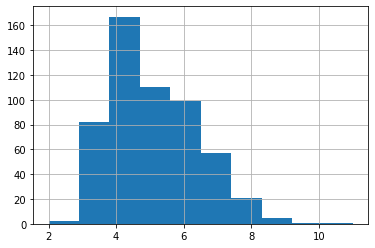

In [15]:
data["lux_home"].hist()

# One-Hot Encoder

In [16]:
data_dummies=pd.get_dummies(data[cat_cols])
data_dummies.head()

,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,2,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0
1,3,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0
2,2,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0
3,3,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0
4,2,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0


In [17]:
data_ord=data[ord_cols]
data_ord.head()

,bedrooms,bathrooms,stories
0,4,2,3
1,4,4,4
2,3,2,2
3,4,2,2
4,4,1,2


In [18]:
list_df = [
    data[['price']],
    data_dummies,
    data_ord,
]

data_fe = pd.concat(list_df, axis=1)
data_fe.shape

(545, 20)

In [19]:
data_fe

,price,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,bedrooms,bathrooms,stories
0,13300000,2,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,4,2,3
1,12250000,3,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,4,4,4
2,12250000,2,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0,3,2,2
3,12215000,3,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,4,2,2
4,11410000,2,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,2,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,2,1,1
541,1767150,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,3,1,1
542,1750000,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,2,1,1
543,1750000,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,3,1,1


In [20]:
corr_matrix = data_fe.corr()
corr_matrix["price"].sort_values(ascending=False)

price                              1.000000
bathrooms                          0.517545
airconditioning_yes                0.452954
stories                            0.420712
parking                            0.384394
bedrooms                           0.366494
prefarea_yes                       0.329777
mainroad_yes                       0.296898
guestroom_yes                      0.255517
furnishingstatus_furnished         0.229350
basement_yes                       0.187057
hotwaterheating_yes                0.093073
furnishingstatus_semi-furnished    0.063656
hotwaterheating_no                -0.093073
basement_no                       -0.187057
guestroom_no                      -0.255517
furnishingstatus_unfurnished      -0.280587
mainroad_no                       -0.296898
prefarea_no                       -0.329777
airconditioning_no                -0.452954
Name: price, dtype: float64

# Train Model

In [21]:
from sklearn.model_selection import train_test_split

cols = data_fe.columns
X = data_fe[[col for col in cols if col != 'price']]
y = data['price']/1.0e6

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
y_pred_lr    = lr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_dt    = dt.predict(X_test)
y_pred_rf    = rf.predict(X_test)

In [24]:
print("Puntaje del conjunto de entrenamiento con regresión lineal: {:.2f}".format(lr.score(X_train, y_train)))
print("Puntaje del conjunto de prueba con regresión lineal: {:.2f}".format(lr.score(X_test, y_test)))
print("--------------------------------------------------------")
print("Puntaje del conjunto de entrenamiento con ridge: {:.2f}".format(ridge.score(X_train, y_train)))
print("Puntaje del conjunto de prueba con ridge: {:.2f}".format(ridge.score(X_test, y_test)))
print("--------------------------------------------------------")
print("Puntaje del conjunto de entrenamiento con lasso: {:.2f}".format(lasso.score(X_train, y_train)))
print("Puntaje del conjunto de prueba con lasso: {:.2f}".format(lasso.score(X_test, y_test)))
print("--------------------------------------------------------")
print("Puntaje del conjunto de entrenamiento con Arbol: {:.2f}".format(dt.score(X_train, y_train)))
print("Puntaje del conjunto de prueba con Arbol: {:.2f}".format(dt.score(X_test, y_test)))
print("--------------------------------------------------------")
print("Puntaje del conjunto de entrenamiento con Random_Forest: {:.2f}".format(rf.score(X_train, y_train)))
print("Puntaje del conjunto de prueba con Random_Forest: {:.2f}".format(rf.score(X_test, y_test)))

Puntaje del conjunto de entrenamiento con regresión lineal: 0.63
Puntaje del conjunto de prueba con regresión lineal: 0.58
--------------------------------------------------------
Puntaje del conjunto de entrenamiento con ridge: 0.63
Puntaje del conjunto de prueba con ridge: 0.58
--------------------------------------------------------
Puntaje del conjunto de entrenamiento con lasso: 0.00
Puntaje del conjunto de prueba con lasso: -0.03
--------------------------------------------------------
Puntaje del conjunto de entrenamiento con Arbol: 0.95
Puntaje del conjunto de prueba con Arbol: 0.27
--------------------------------------------------------
Puntaje del conjunto de entrenamiento con Random_Forest: 0.90
Puntaje del conjunto de prueba con Random_Forest: 0.58


# Errores Residuales

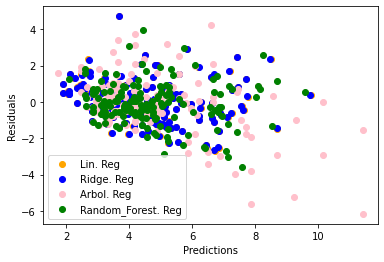

In [25]:
plt.scatter(y_pred_lr    , y_test-y_pred_lr,    color='orange', label='Lin. Reg')
plt.scatter(y_pred_ridge , y_test-y_pred_ridge, color='blue',   label='Ridge. Reg')
#lt.scatter(y_pred_lasso , y_test-y_pred_lasso, color='red',    label='Lasso. Reg')
plt.scatter(y_pred_dt,  y_test-y_pred_dt, color="pink",label='Arbol. Reg')
plt.scatter(y_pred_rf    , y_test-y_pred_rf, color='green',    label='Random_Forest. Reg')


plt.legend()

plt.ylabel('Residuals')
plt.xlabel('Predictions');

Text(0, 0.5, 'Frequency')

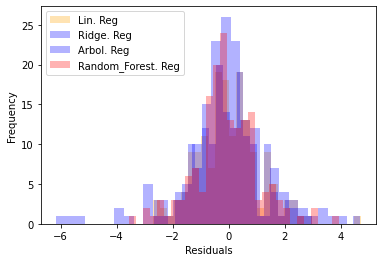

In [26]:
plt.hist(y_test-y_pred_lr,    bins=30, color='orange', label='Lin. Reg',   alpha=0.3)
plt.hist(y_test-y_pred_ridge, bins=30, color='blue',   label='Ridge. Reg', alpha=0.3)
#plt.hist(y_test-y_pred_lasso, bins=30, color='red',    label='Lasso. Reg', alpha=0.3)
plt.hist(y_test-y_pred_dt,    bins=30, color='blue',   label='Arbol. Reg', alpha=0.3)
plt.hist(y_test-y_pred_rf,    bins=30, color='red',    label='Random_Forest. Reg', alpha=0.3)

plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

print('Model', 'MSE','R2')
print("--------------------------------------------------------")
print('Lineal.         Reg',mean_squared_error(y_test, y_pred_lr),    r2_score(y_test, y_pred_lr) )
print('Ridge.          Reg',mean_squared_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge) )
print('Lasso.          Reg',mean_squared_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso) )
print('Arbol.          Reg',mean_squared_error(y_test, y_pred_dt), r2_score(y_test, y_pred_dt) )
print('Random_Forest.  Reg',mean_squared_error(y_test, y_pred_rf), r2_score(y_test, y_pred_rf) )

Model MSE R2
--------------------------------------------------------
Lineal.         Reg 1.3147229444783664 0.5808407608665459
Ridge.          Reg 1.3100529388440723 0.5823296494697613
Lasso.          Reg 3.233119504755159 -0.030781365254405557
Arbol.          Reg 2.3052574549016938 0.2650390982666715
Random_Forest.  Reg 1.3144390291345152 0.580931278598823


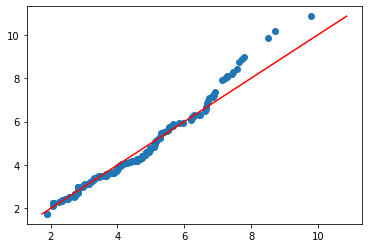

In [28]:
# QQ plot

plt.scatter(np.sort(y_pred_lr), np.sort(y_test))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')

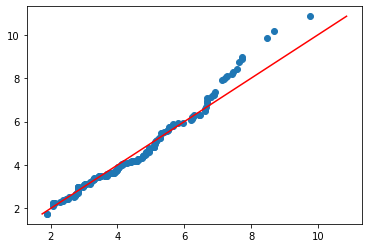

In [29]:
plt.scatter(np.sort(y_pred_ridge), np.sort(y_test))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')

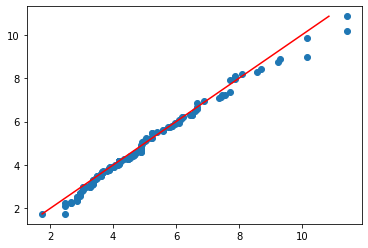

In [30]:
plt.scatter(np.sort(y_pred_dt), np.sort(y_test))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')

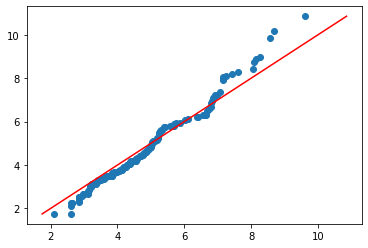

In [31]:
plt.scatter(np.sort(y_pred_rf), np.sort(y_test))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')